#Related Env: prs

In [117]:
from pyraysum import prs, Geometry, Model, Control
import numpy as np
import os
import obspy as op
import pandas as pd
from numpy.linalg import norm
from scipy.optimize import dual_annealing, rosen, shgo, differential_evolution
from scipy import signal
import matplotlib.pyplot as plt
from scipy.optimize import LinearConstraint, Bounds
import ast



In [118]:
def read_layers(layers=3, **kwargs):
    models = pd.read_csv("inv/initial/all_layers.csv")
    models = models[models["layer_code"] == layers]
    selected_model = models[["thickn", "rho", "vp", "vs", "dip", "strike", "plunge", "trend", "ani"]]
    # bounds
    bounds_from_file = pd.read_csv("inv/initial/bounds.csv")
    df = bounds_from_file[bounds_from_file["layer_code"] == layers]
    df = df.drop(columns=["layer_code"])
    bounds = []
    for key in df.keys():
        for row in df[key]:
            each_bound = ast.literal_eval(row)
            each_bound = (float(each_bound[0]), int(each_bound[1]))
            bounds.append(ast.literal_eval(row))
    bounds = [i for i in bounds if i != (0, 0)]
    return selected_model.reset_index(), bounds

def pyraysum_func(baz, slow, thickn, rho, vp, vs, dip, strike, plunge, trend, ani, npts, dt):
    # flag = [1 if i == 0 else 0 for i in ani]
    flag = [1 for i in ani]
    model = Model(thickn, rho, vp, vs=vs, strike=strike, dip=dip, flag=flag, plunge=plunge, trend=trend, ani=ani)
    geom = Geometry(baz, slow)
    rc = Control(wvtype="P", rot="RTZ", mults=2, verbose=False, npts=npts*1, dt=dt, align=1, shift=5)
    result = prs.run(model, geom, rc, rf=True)
    result.filter('rfs', 'lowpass', freq=1., zerophase=True, corners=2)
    return model, geom, result


def cost_func(x, model, geom, obser_rf, layers):
    global updated_model
    if layers == 2:               # 2-layer model
        model.loc[0, "thickn"] = int(x[0])
        model.loc[1, "thickn"] = 0
        model.loc[[0, 1], "rho"] = np.int_(x[1:3])
        model.loc[[0, 1], "vp"] = np.int_(x[3:5])
        model.loc[[0, 1], "vs"] = np.int_(x[5:7])
        try:
            model.loc[0, "dip"] = 0
            model.loc[1, "dip"] = x[7]
            model.loc[0, "strike"] = 0
            model.loc[1, "strike"] = x[8]
            model.loc[[0, 1], "plunge"] = x[9:11]
            model.loc[[0, 1], "trend"] = x[11:13]
            model.loc[[0, 1], "ani"] = x[13:15]
        except:
            pass
    elif layers == 3:             # 3-layer model
        model.loc[[0, 1], "thickn"] = np.int_(x[0:2])
        model.loc[2, "thickn"] = 0
        model.loc[[0, 1, 2], "rho"] = np.int_(x[2:5])
        model.loc[[0, 1, 2], "vp"] = np.int_(x[5:8])
        model.loc[[0, 1, 2], "vs"] = np.int_(x[8:11])
        try:
            model.loc[0, "dip"] = 0
            model.loc[[1, 2], "dip"] = x[11:13]
            model.loc[0, "strike"] = 0
            model.loc[[1, 2], "strike"] = x[13:15]
            model.loc[[0, 1, 2], "plunge"] = x[15:18]
            model.loc[[0, 1, 2], "trend"] = x[18:21]
            model.loc[[0, 1, 2], "ani"] = x[21:24]
        except:
            pass
    elif layers == 4:             # 4-layer model
        model.loc[[0, 1, 2], "thickn"] = np.int_(x[0:3])
        model.loc[3, "thickn"] = 0
        model.loc[[0, 1, 2, 3], "rho"] = np.int_(x[3:7])
        model.loc[[0, 1, 2, 3], "vp"] = np.int_(x[7:11])
        model.loc[[0, 1, 2, 3], "vs"] = np.int_(x[11:15])
        try:
            model.loc[0, "dip"] = 0
            model.loc[[1, 2, 3], "dip"] = x[15:18]
            model.loc[0, "strike"] = 0
            model.loc[[1, 2, 3], "strike"] = x[18:21]
            model.loc[[0, 1, 2, 3], "plunge"] = x[21:25]
            model.loc[[0, 1, 2, 3], "trend"] = x[25:29]
            model.loc[[0, 1, 2, 3], "ani"] = x[29:33]
        except:
            pass
    elif layers == 5:             # 5-layer model
        model.loc[[0, 1, 2, 3], "thickn"] = np.int_(x[0:4])
        model.loc[4, "thickn"] = 0
        model.loc[[0, 1, 2, 3, 4], "rho"] = np.int_(x[4:9])
        model.loc[[0, 1, 2, 3, 4], "vp"] = np.int_(x[9:14])
        model.loc[[0, 1, 2, 3, 4], "vs"] = np.int_(x[14:19])
        try:
            model.loc[0, "dip"] = 0
            model.loc[[1, 2, 3, 4], "dip"] = x[19:23]
            model.loc[0, "strike"] = 0
            model.loc[[1, 2, 3, 4], "strike"] = x[23:27]
            model.loc[[0, 1, 2, 3, 4], "plunge"] = x[27:32]
            model.loc[[0, 1, 2, 3, 4], "trend"] = x[32:37]
            model.loc[[0, 1, 2, 3, 4], "ani"] = x[37:42]
        except:
            pass
    elif layers == 6:             # 6-layer model
        model.loc[[0, 1, 2, 3, 4], "thickn"] = np.int_(x[0:5])
        model.loc[5, "thickn"] = 0
        model.loc[[0, 1, 2, 3, 4, 5], "rho"] = np.int_(x[5:11])
        model.loc[[0, 1, 2, 3, 4, 5], "vp"] = np.int_(x[11:17])
        model.loc[[0, 1, 2, 3, 4, 5], "vs"] = np.int_(x[17:23])
        try:
            model.loc[0, "dip"] = 0
            model.loc[[1, 2, 3, 4, 5], "dip"] = x[23:28]
            model.loc[0, "strike"] = 0
            model.loc[[1, 2, 3, 4, 5], "strike"] = x[28:33]
            model.loc[[0, 1, 2, 3, 4, 5], "plunge"] = x[33:39]
            model.loc[[0, 1, 2, 3, 4, 5], "trend"] = x[39:45]
            model.loc[[0, 1, 2, 3, 4, 5], "ani"] = x[45:51]
        except:
            pass
    elif layers == 7:             # 7-layer model
        model.loc[[0, 1, 2, 3, 4, 5], "thickn"] = np.int_(x[0:6])
        model.loc[6, "thickn"] = 0
        model.loc[[0, 1, 2, 3, 4, 5, 6], "rho"] = np.int_(x[6:13])
        model.loc[[0, 1, 2, 3, 4, 5, 6], "vp"] = np.int_(x[13:20])
        model.loc[[0, 1, 2, 3, 4, 5, 6], "vs"] = np.int_(x[20:27])
        try:
            model.loc[0, "dip"] = 0
            model.loc[[1, 2, 3, 4, 5, 6], "dip"] = x[27:33]
            model.loc[0, "strike"] = 0
            model.loc[[1, 2, 3, 4, 5, 6], "strike"] = x[33:39]
            model.loc[[0, 1, 2, 3, 4, 5, 6], "plunge"] = x[39:46]
            model.loc[[0, 1, 2, 3, 4, 5, 6], "trend"] = x[46:53]
            model.loc[[0, 1, 2, 3, 4, 5, 6], "ani"] = x[53:60]
        except:
            pass
    
    updated_model = model
    obser_data = obser_rf
    pred_data, _ = predict(geom, model)
    mat_rfr = np.subtract(pred_data, obser_data)
    eps_thickn = 0.02
    eps_vp = 0.01
    k = [model["vp"][ii]/model["vp"][ii] for ii in range(len(model["vp"])-1)]
    error = norm(mat_rfr, 'fro') + eps_thickn * np.abs(np.sum(model["thickn"]) - 35_500)
    pred_stacked = stack_rfs(pred_data)
    obser_stacked = stack_rfs(obser_data)
    error = norm(pred_stacked - obser_stacked, 2) #+ eps_thickn * np.abs(np.sum(model["thickn"]) - 40_000)
    return error
        
def reading_rfs(keyword):
    """
    Reading RF data by the name of keyword as station code
    """
    baz = []
    slow = []
    path = "DATA/waveforms_list.csv"
    waveforms_list = pd.read_csv(path)
    filtered_files = waveforms_list[waveforms_list['sta_code']==keyword].copy()
    filtered_files = filtered_files[filtered_files['rf_quality'] == 1].copy()
    path = "DATA/RF/"
    npts = 426 * 1   
    dt = 0.2
    obser_data = np.zeros((len(filtered_files), npts))
    idx = 0
    for index, row in filtered_files.iterrows():
        wave_path = os.path.join(path, row['file_name']+".pkl")
        st = op.read(wave_path)
        RFR = st.select(channel="RFR")[0].filter('bandpass', freqmin=0.05, freqmax=0.5, corners=4, zerophase=True).normalize().data
        # RFT = st.select(channel="RFT")[0].filter('bandpass', freqmin=0.05, freqmax=0.25, corners=4, zerophase=True).normalize().data
        baz.append(st[0].stats.baz)
        slow.append(st[0].stats.slow)
        obser_data[idx, :] = RFR
        idx += 1
    return obser_data, baz, slow

def stack_rfs(rf_matrix):
    """
    Stacking the RF data in the matrix
    """
    return np.mean(rf_matrix, axis=0)

def predict(geom, model):
    model, _, result = pyraysum_func(geom["baz"], geom["slow"], model["thickn"], model["rho"], model["vp"], model["vs"], model["dip"],
                                     model["strike"], model["plunge"], model["trend"], model["ani"], 3*426, 0.2)
    pred_data = np.zeros((len(result), 3*426))   
    for idx, i in enumerate(result):
        RFR = i[1][0]
        RFR.data = signal.decimate(RFR.data, 1)
        RFR = RFR.filter('bandpass', freqmin=0.05, freqmax=0.5, corners=4, zerophase=True).normalize().data
        # RFT = i[1][1].filter('bandpass', freqmin=0.05, freqmax=0.5, corners=2, zerophase=True).normalize().data
        pred_data[idx, :] = RFR
        #reducing the length of the data to 426
    pred_data = pred_data[:, 426:2*426]
    return pred_data, model

def print_and_save(scipy_result, station, layers):
    dict_result = {"layers": layers,
                   "fun": round(scipy_result.fun, 3),
                   "num_iter": scipy_result.nit,
                   "num_func_eval": scipy_result.nfev}
    print(dict_result)
    df = pd.DataFrame(dict_result, index=[0])
    df.to_csv(f"inv/results/{station}_layers_{layers}_result.csv", index=False)

def do_inversion(cost_func, bounds, initial_model, geom, obser_data, layers, method="dual_ann", verbose=False):
    thickn_lc = np.zeros(len(bounds))
    thickn_lc[0:layers-1] = 1
    lc1 = LinearConstraint([thickn_lc], 30_000, 45_000)     # linear constraint 3 - thickness
    if method in ["dual_ann", "dual_annealing", "dual"]:
        results = dual_annealing(cost_func,                         # cost function func(x, *args)
                         bounds,                            # list of (min, max) pairs for each element in x
                         args=(initial_model, geom, obser_data, layers),
                         maxiter=15,
                         seed=42, 
                         )
    elif method in ["diff_evol","differential_evolution","diff"]:
        results = differential_evolution(cost_func,                         # cost function func(x, *args)
                         bounds,                            # list of (min, max) pairs for each element in x
                         args=(initial_model, geom, obser_data, layers),
                         maxiter=15,
                         constraints=[lc1],
                         disp=verbose
                         )
    elif method == "shgo":
        pass

    return results        
    

## Controlling Block

In [119]:
layers = 6
station = "SHMN"
obser_data, baz, slow= reading_rfs(station)
if 0:
        limit = 6
        obser_data, baz, slow = obser_data[:limit], baz[:limit], slow[:limit]
print(f"Number of RFs: {len(obser_data)}")

geom = {"baz": baz,
        "slow": slow}

initial_model, bounds = read_layers(layers=layers)
print("===== Initial Model =====".center(20))
print(initial_model)
print("Bounds")
# print(bounds)
# print(len(bounds))


Number of RFs: 42
===== Initial Model =====
   index  thickn   rho    vp    vs  dip  strike  plunge  trend  ani
0     14    4000  2200  6000  3000    0       0       0      0    0
1     15    5000  2300  6100  3300    0       0       0      0    0
2     16    6000  2500  6200  3700    0       0       0      0    0
3     17   10000  2900  6400  4000    0       0       0      0    0
4     18   10000  3000  6700  4500    0       0       0      0    0
5     19       0  3200  8000  5000    0       0       0      0    0
Bounds


### Inversion

In [120]:
#Modeling the data
results = do_inversion(cost_func, bounds, initial_model, geom, obser_data, layers, 
                       verbose=False, method="diff_evol")
#saving the new model
updated_model.to_csv(f"inv/results/{station}_layers_{layers}_updated_model.csv", index=False)

/opt/miniconda3/envs/prs/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/opt/miniconda3/envs/prs/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


{'layers': 6, 'fun': 0.708, 'num_iter': 15, 'num_func_eval': 3495}


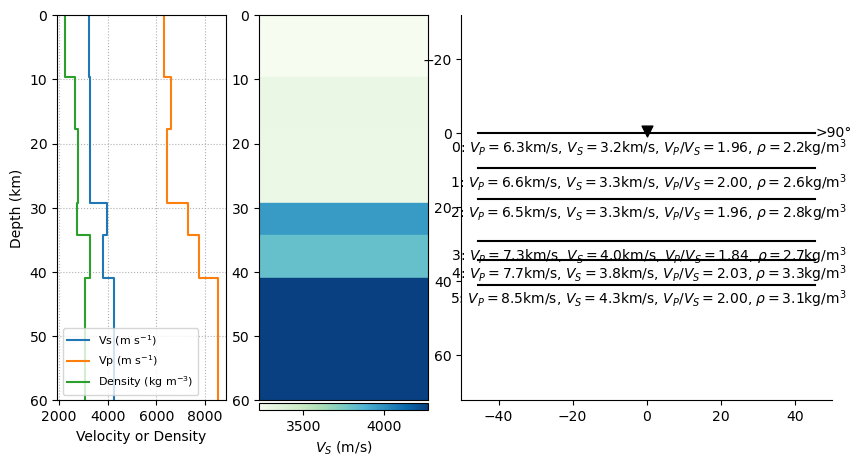

In [121]:
print_and_save(results, station, layers)
# updated model is a global variable
pred_data, model = predict(geom, updated_model)
# !!! for saving the plot, I have changed the prs.py file to return the fig in the plot() function. Also add a keyword argument to the plot() function named "show" to show the plot or not.
fig = model.plot(zmax=60, show=True)
fig.savefig(f"inv/results/{station}_layers_{layers}_updated_model.png")

   index  thickn   rho    vp    vs  dip  strike  plunge  trend  ani
0     14    9537  2239  6321  3226    0       0       0      0    0
1     15    8251  2649  6602  3296    0       0       0      0    0
2     16   11431  2789  6450  3291    0       0       0      0    0
3     17    5031  2736  7295  3960    0       0       0      0    0
4     18    6706  3298  7746  3810    0       0       0      0    0
5     19       0  3063  8526  4271    0       0       0      0    0


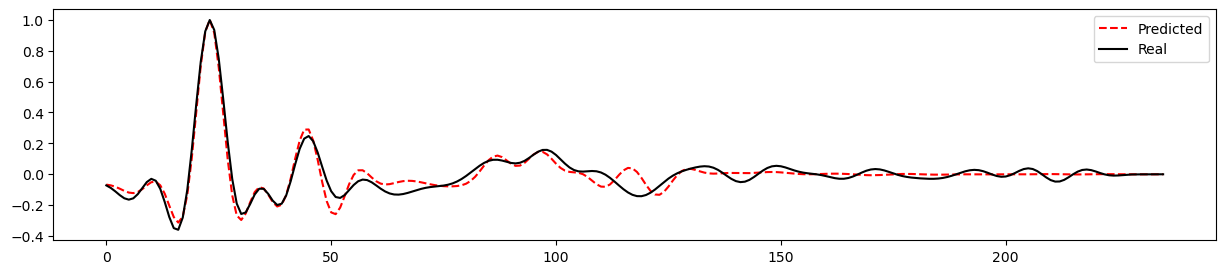

In [122]:
pred_data, model = predict(geom, updated_model)
print(updated_model.head(layers))

pred_stacked = stack_rfs(pred_data)
obser_stacked = stack_rfs(obser_data)
fig = plt.figure(figsize=(15,3))
plt.plot(pred_stacked[190:], label="Predicted", linestyle="--", color="red")
plt.plot(obser_stacked[190:], label="Real", color="black")
plt.legend()
plt.show()
fig.savefig(f"inv/results/{station}_layers_{layers}_stacked.png")


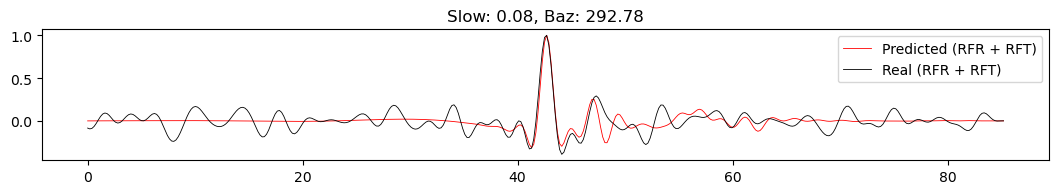

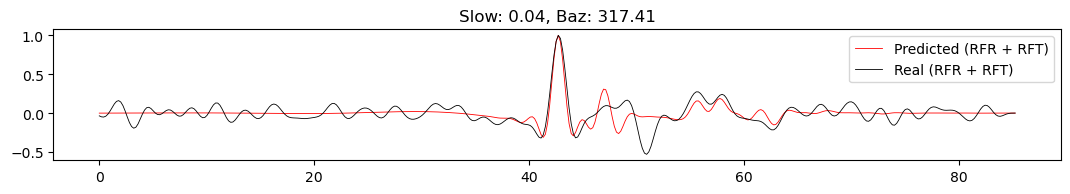

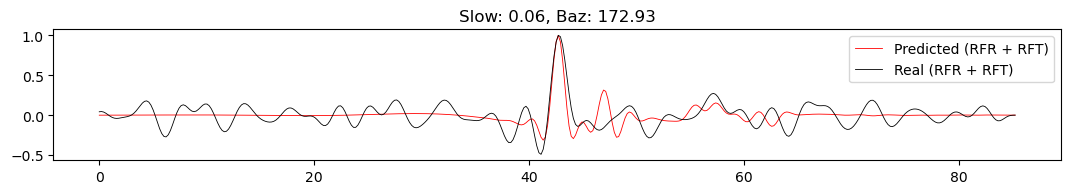

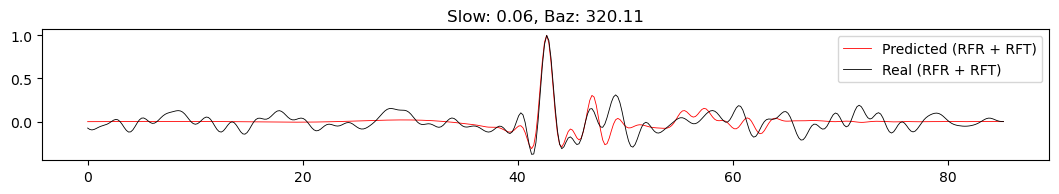

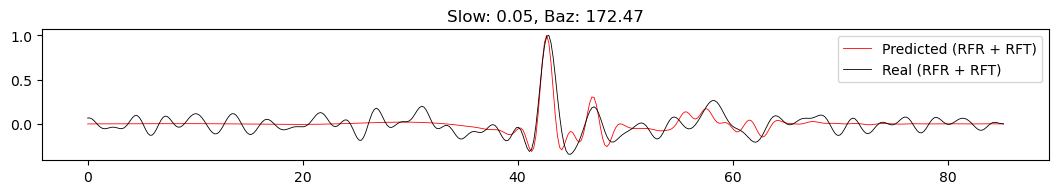

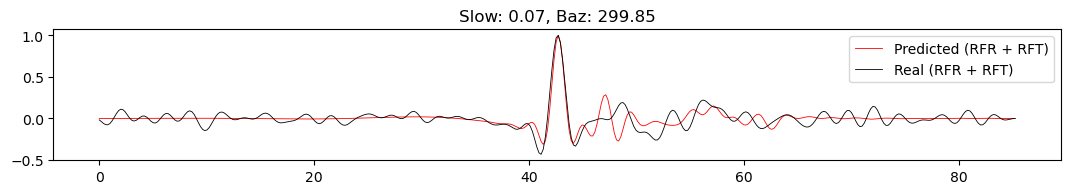

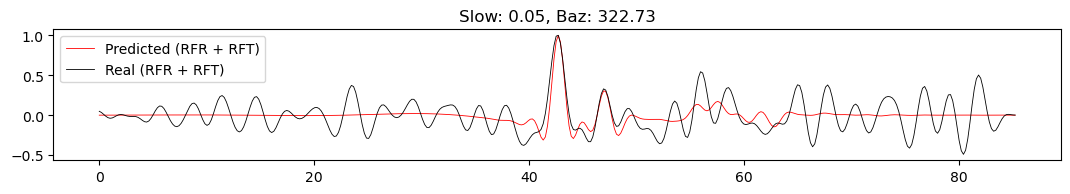

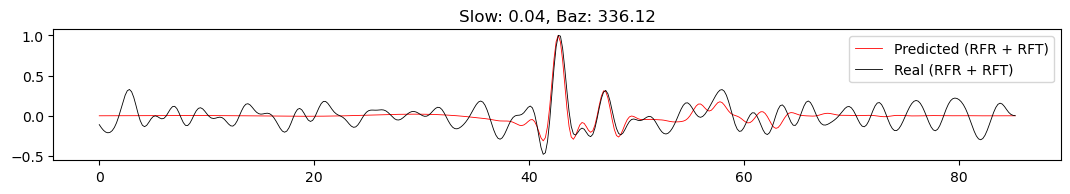

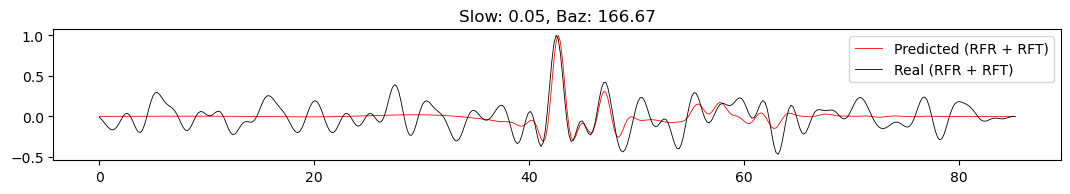

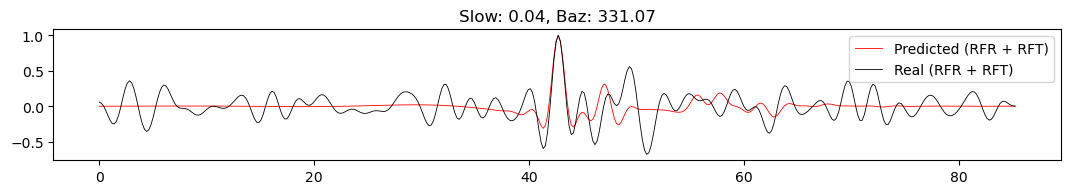

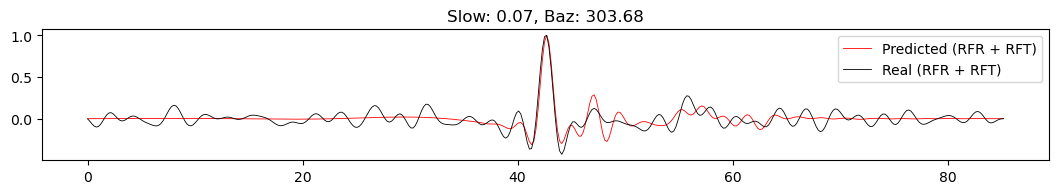

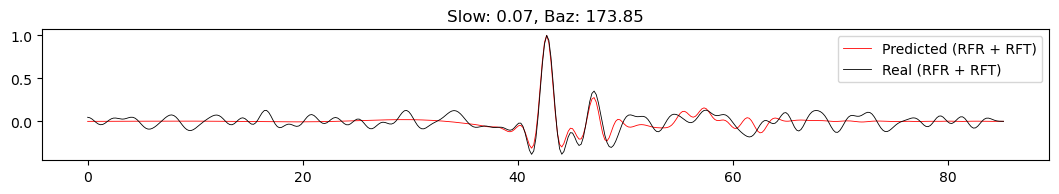

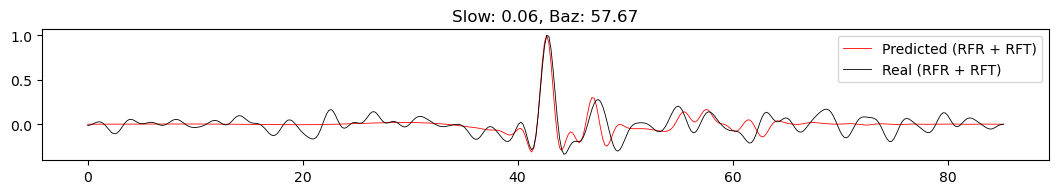

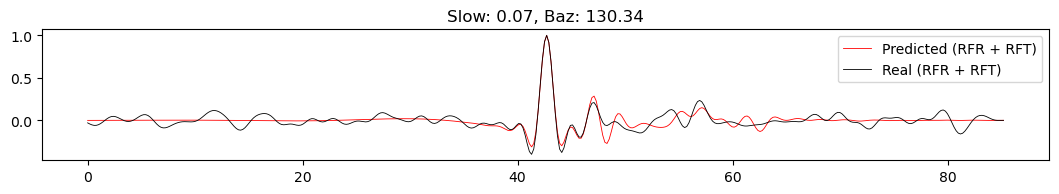

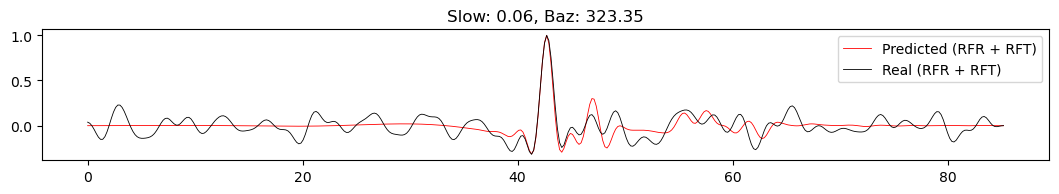

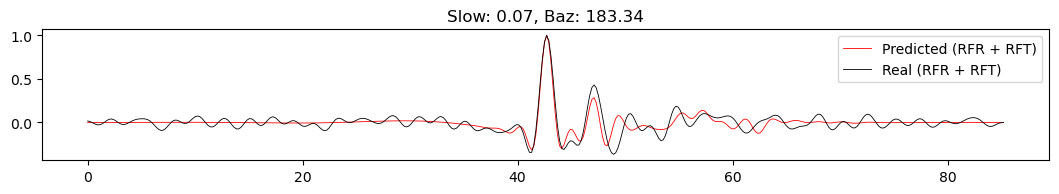

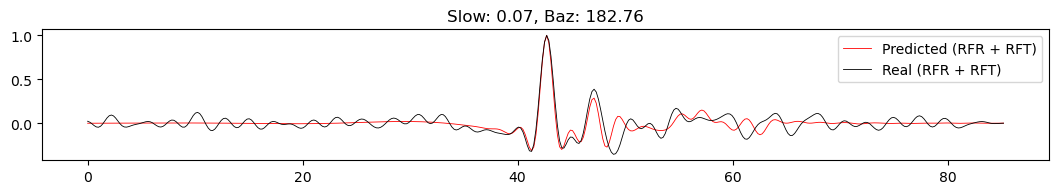

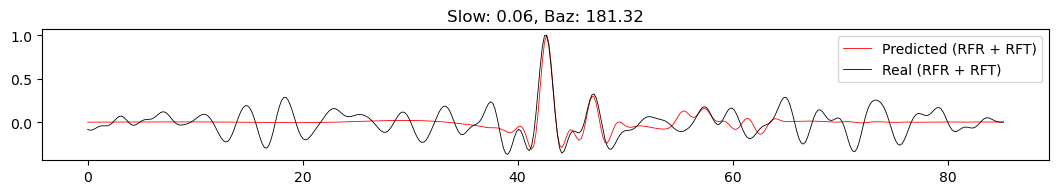

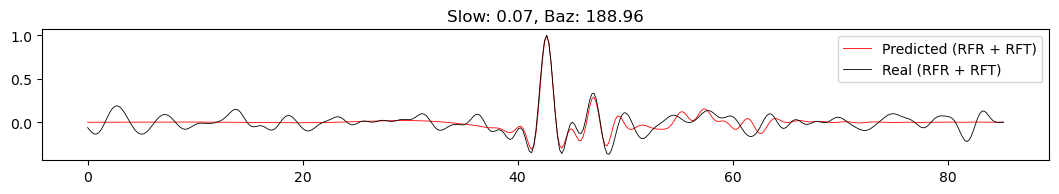

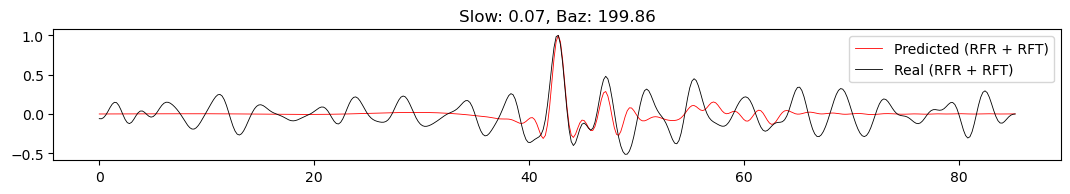

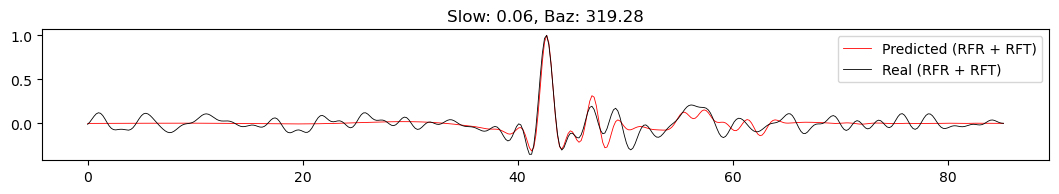

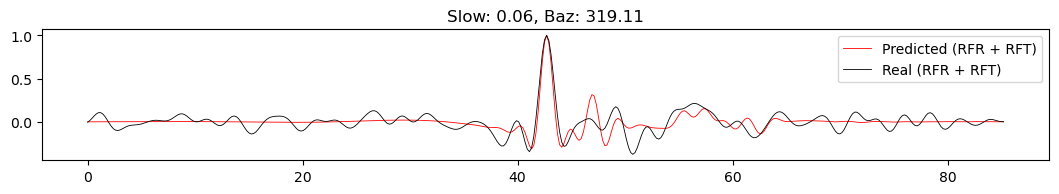

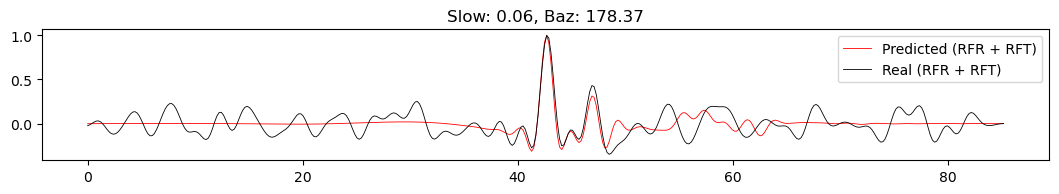

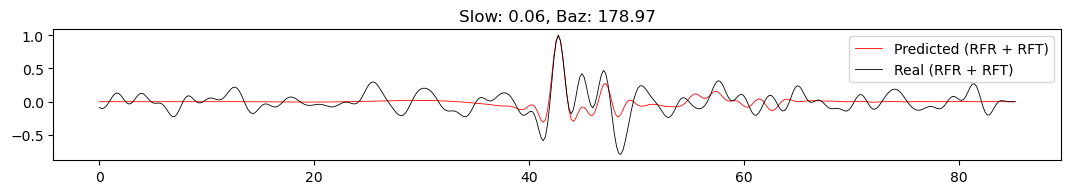

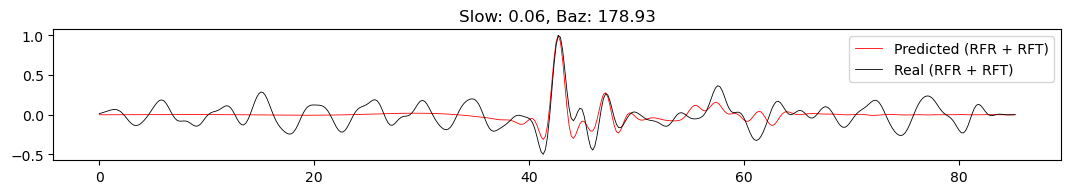

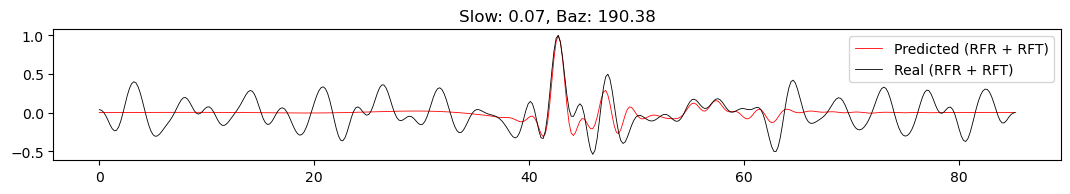

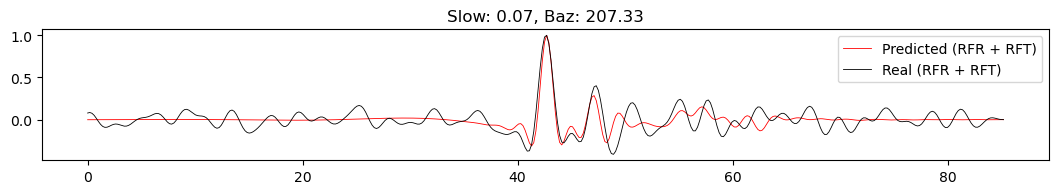

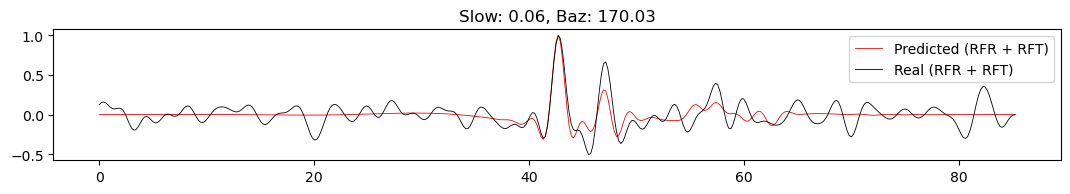

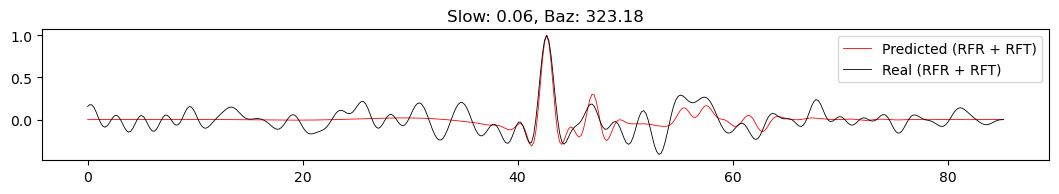

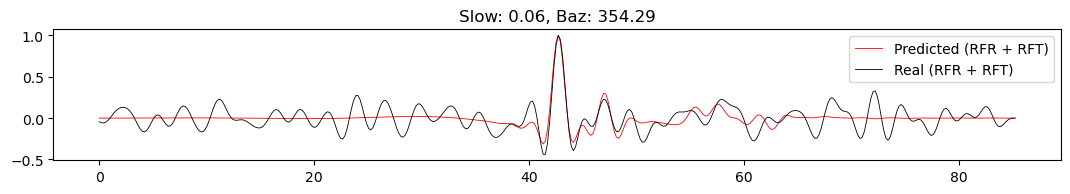

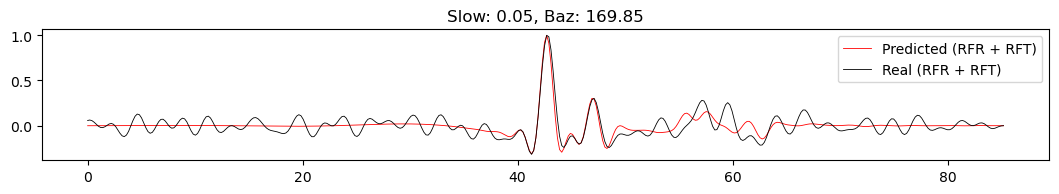

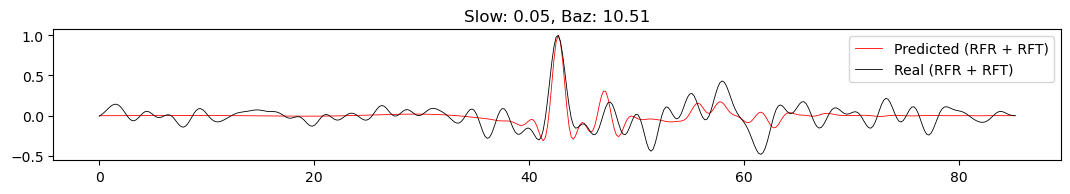

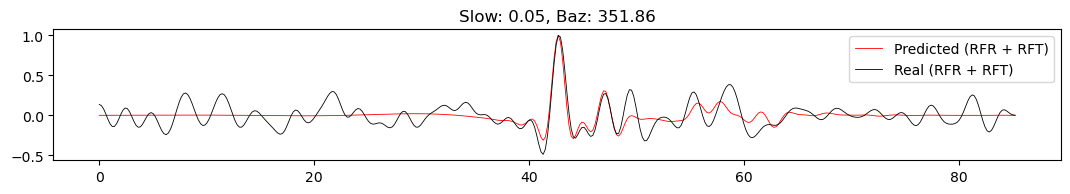

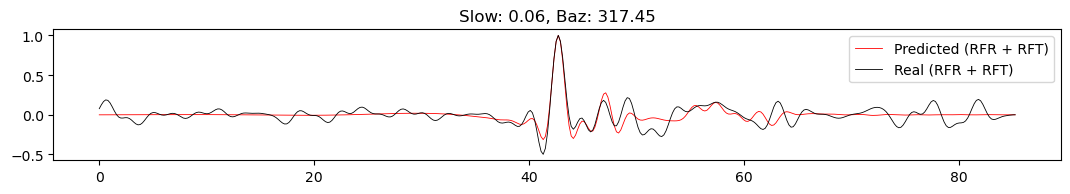

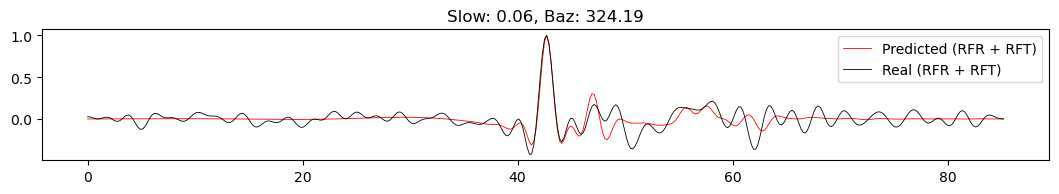

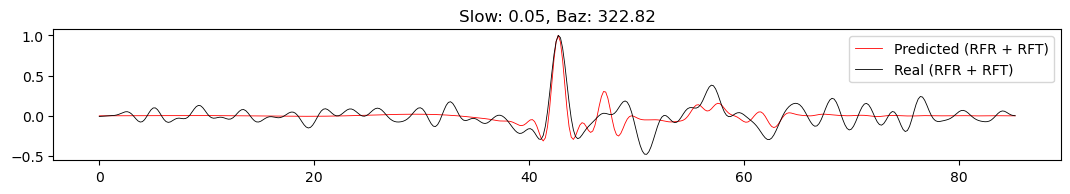

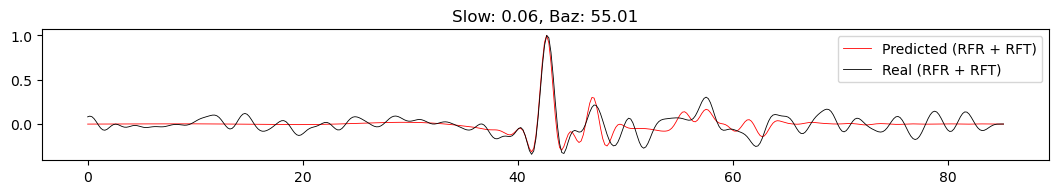

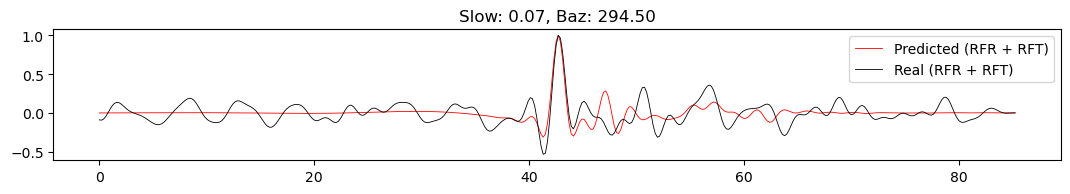

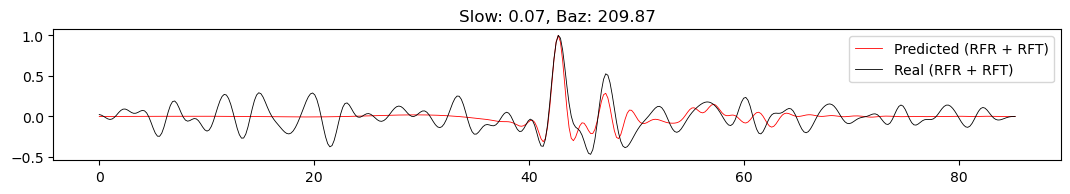

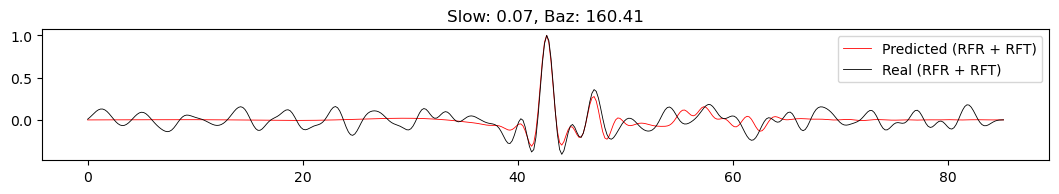

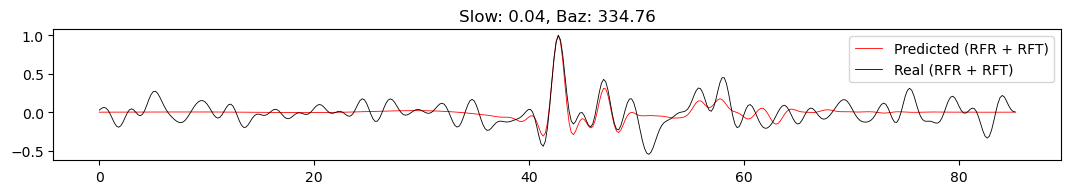

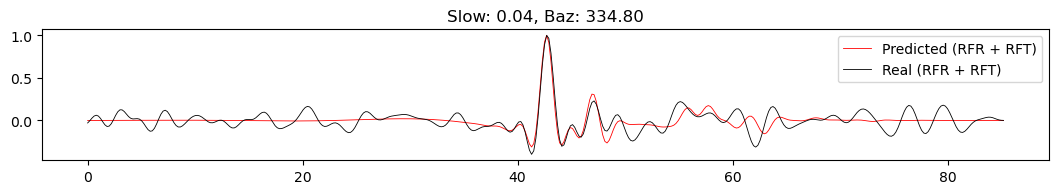

In [123]:
for wave_num in range(len(pred_data)):
    data_pred, _ = predict(geom, updated_model)
    time = np.linspace(0, 0.2*426, data_pred.shape[1])#[0:215]
    time_shift = time + 0.
    plt.figure(figsize=(13, 1.7))
    plt.plot(time, data_pred[wave_num,:], 'r', label="Predicted (RFR + RFT)", linewidth=0.6)
    plt.plot(time_shift,obser_data[wave_num,:], 'black', linewidth=0.6, label="Real (RFR + RFT)")
    # plt.axvline(x=len(time)/4*0.2, color='black', linestyle='--', linewidth=0.6)
    # plt.axvline(x=len(time)*0.75*0.2, color='black', linestyle='--', linewidth=0.6)
    plt.title(f"Slow: {slow[wave_num]:.2f}, Baz: {baz[wave_num]:.2f}")
    plt.legend()
    plt.show()
